# Assignment 2 - Image Inpainting

Name: Tea Pula
Matriculation number: 23-125-578

In [1]:
from numpy import *
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
from scipy import sparse
from scipy.signal import convolve2d
import numpy as np
from hessian_matrix import *

## Test Image

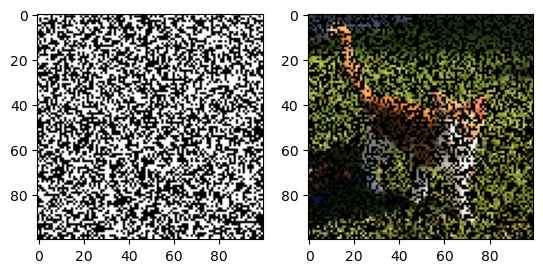

In [2]:
masked_img = np.array(Image.open('masked_cat.png')) / 255
omega = np.array(Image.open('mask.png')) / 255
g = masked_img

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(omega, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(g)

## hessian_matrix() function

We provide the implementation of the hessian matrix.

input variables: 
- u: your image
- omega: binary mask
- reg: regularization parameter

Example usage:

In [3]:
u_ex = np.zeros(9).reshape(3, 3)
reg_ex = 1
k_type_ex = 3
A = hessian_matrix(u_ex, omega, reg_ex)
A_n_t = A.toarray()
print(A_n_t)

[[ 4. -2.  0. -2.  0.  0.  0.  0.  0.]
 [-2.  8. -2.  0. -2.  0.  0.  0.  0.]
 [ 0. -2.  6.  0.  0. -2.  0.  0.  0.]
 [-2.  0.  0.  8. -2.  0. -2.  0.  0.]
 [ 0. -2.  0. -2. 10. -2.  0. -2.  0.]
 [ 0.  0. -2.  0. -2.  8.  0.  0. -2.]
 [ 0.  0.  0. -2.  0.  0.  6. -2.  0.]
 [ 0.  0.  0.  0. -2.  0. -2.  6. -2.]
 [ 0.  0.  0.  0.  0. -2.  0. -2.  6.]]


## Implementation


In [4]:
import numpy as np


def GD(g, omega, lmbda):
    """
    Gradient Descent algorithm
    g: masked image of size (M, N, 3)
    omega: binary mask of size (M, N)
    lmbda: regularization parameter
    """
    # initialize the reconstructed inpainted image with the masked image
    u = g.copy()
    # maximum number of iterations
    iterations = 1000
    # gradient descent convergence threshold, 0.000001 very close to 0
    convergence_threshold = 1e-6

    # iterate 1000 times to minimize the energy function or stop if convergence threshold is reached faster
    for iteration in range(iterations):
        energy_gradient = calculateEnergyGradient(u, g, omega, lmbda)
        #the gradient descent update function
        u_hat = u - lmbda * energy_gradient
        u = u_hat

        if (np.linalg.norm(energy_gradient) < convergence_threshold):
            break

    return u


def calculateEnergyGradient(u, g, omega, lmbda):
    energy_gradient = np.zeros(u.shape, dtype="float")
    rows, columns, channels = u.shape
    N = rows - 1
    M = columns - 1

    #this function handles the eight special cases that are explained in detail in the report.
    for i in range(rows):
        for j in range(columns):
            #Inner pixels case (not on the boundaries)
            if i > 0 and i < N and j > 0 and j < M:
                energy_gradient[i, j] = 2 * omega[i, j] * (u[i, j] - g[i, j]) + 2 * lmbda * (
                            4 * u[i, j] - u[i + 1, j] - u[i, j + 1] - u[i - 1, j] - u[i, j - 1])
                #Top-left corner [1,1]
            elif i == 0 and j == 0:
                energy_gradient[0, 0] = 2 * omega[0, 0] * (u[0, 0] - g[0, 0]) + 2 * lmbda * (
                            2 * u[0, 0] - u[1, 0] - u[0, 1])
            #Top-right corner [1,M]
            elif i == 0 and j == M:
                energy_gradient[0, M] = 2 * omega[0, M] * (u[0, M] - g[0, M]) + 2 * lmbda * (
                            2 * u[0, M] - u[0, M - 1] - u[1, M])
            #Bottom-left corner [N,1]
            elif i > N and j == 1:
                energy_gradient[N, 0] = 2 * omega[N, 0] * (u[N, 0] - g[N, 0]) + 2 * lmbda * (
                            2 * u[N, 0] - u[N - 1, 0] - u[N, 1])
            #Bottom-right corner [N,M]
            elif i > N and j < M:
                energy_gradient[N, M] = 2 * omega[N, M] * (u[N, M] - g[N, M]) + 2 * lmbda * (
                            2 * u[N, M] - u[N, M - 1] - u[N - 1, M])
            #Top boundary [1,j]
            elif i == 0 and j > 0 and j < M:
                energy_gradient[0, j] = 2 * omega[0, j] * (u[0, j] - g[0, j]) + 2 * lmbda * (
                            3 * u[0, j] - u[0, j - 1] - u[1, j] - u[0, j + 1])
            #Left boundary [i,1]
            elif i > 0 and i < N and j == 0:
                energy_gradient[i, 0] = 2 * omega[i, 0] * (u[i, 0] - g[i, 0]) + 2 * lmbda * (
                            3 * u[i, 0] - u[i - 1, 0] - u[i, 1] - u[i + 1, 0])
            #Bottom boundary [N,j]
            elif i == N and j > 0 and j < M:
                energy_gradient[N, j] = 2 * omega[N, j] * (u[N, j] - g[N, j]) + 2 * lmbda * (
                            3 * u[N, j] - u[N, j - 1] - u[N - 1, j] - u[N, j + 1])
            #Right boundary [i,M]
            elif i > 0 and i < N and j == M:
                energy_gradient[i, M] = 2 * omega[i, M] * (u[i, M] - g[i, M]) + 2 * lmbda * (
                            3 * u[i, M] - u[i - 1, M] - u[i, M - 1] - u[i + 1, M])

    return energy_gradient

In [5]:
from scipy.sparse import triu, tril, diags


def LGS(g, omega, lmbda):
    """
    Gradient Descent algorithm
    g: masked image of size (M, N, 3)
    omega: binary mask of size (M, N)
    lmbda: regularization parameter
    """
    u = np.copy(g)

    # maximum number of iterations for solving the linear system
    iterations = 50
    # convergence threshold (difference between previous and latest values), 0.000001 very close to 0
    convergence_threshold = 1e-6

    # iterate 50 times to update minimized values of the linear system, stop if convergence threshold is reached faster
    for iteration in range(iterations):
        u_hat = solve_with_gauss_seidel(u, g, omega, lmbda)

        if (np.linalg.norm(u - u_hat) < convergence_threshold):
            break

        u = u_hat

    return u


def solve_with_gauss_seidel(u, g, omega, lmbda):
    N, M, _ = u.shape
    # hessian is applied to approximate the difference in gradients
    H = hessian_matrix(u, omega, lmbda)

    energy_gradient = calculateEnergyGradient(u, g, omega, lmbda)
    b = ((H * u.reshape(-1, 3)).reshape(N, M, 3) - energy_gradient).reshape(-1, 3)
    U = sparse.triu(H, k=1).tocsr()
    L = sparse.tril(H).tocsr()

    #it is initialized to a matrix of zeros so then each element is updated with newest value
    u_hat = np.zeros((N * M, 3))

    for i in range(N * M):
        u_hat[i] = (b[i] - L[i] @ u_hat - U[i] @ u.reshape(-1, 3)) / H[i, i]

    return u_hat.reshape(N, M, 3)


## GRADIENT DESCENT

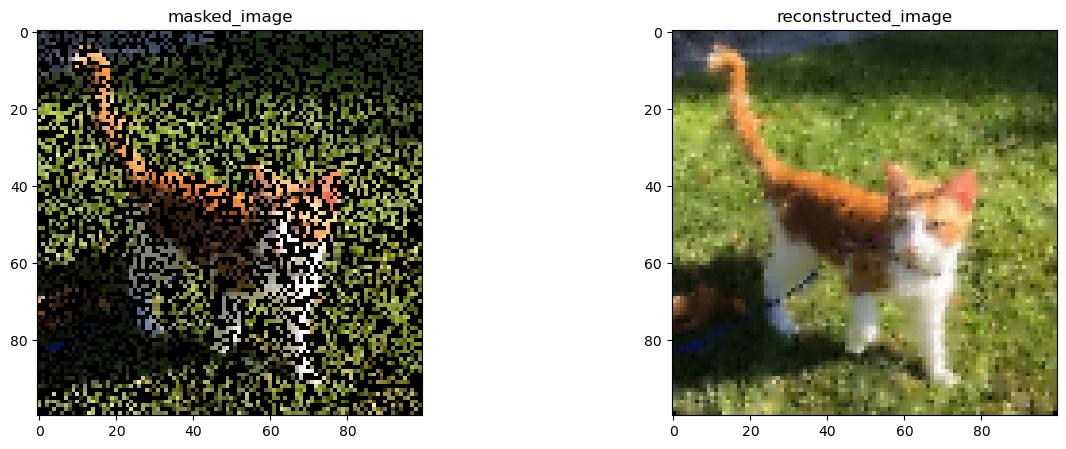

In [6]:
# run gradient descent algorithm
reg_lambda = 0.1

inpainted_img_gd = GD(masked_img, omega, reg_lambda)

# for visualization purpose 
inpainted_img_gd = np.clip(inpainted_img_gd, 0, 1)

plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 2, 1)
plt.imshow(masked_img)
ax2 = plt.subplot(1, 2, 2)
plt.imshow(inpainted_img_gd)

ax1.set_title("masked_image")
ax2.set_title("reconstructed_image")
plt.show()

## GAUSS - SEIDEL

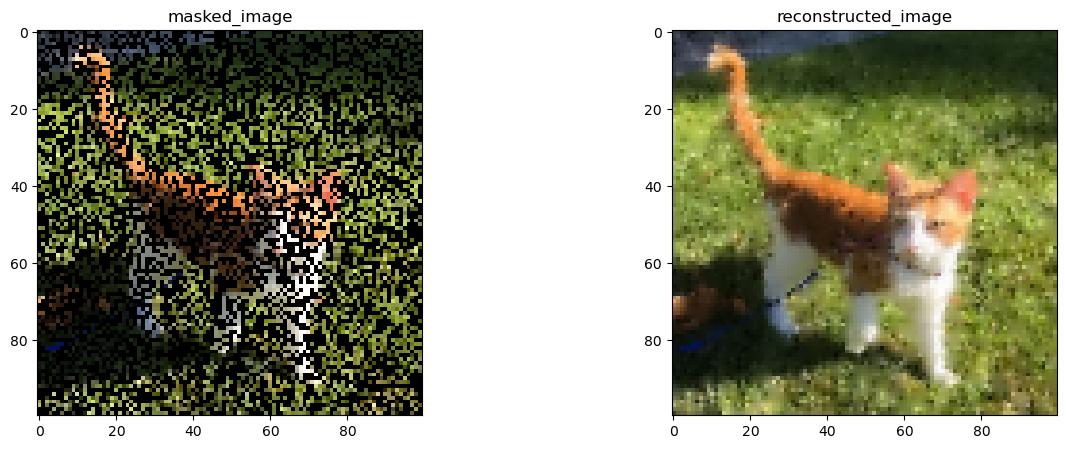

In [7]:
# run gradient descent algorithm
inpainted_img_lgs = LGS(masked_img, omega, reg_lambda)

# for visualization purpose 
inpainted_img_lgs = np.clip(inpainted_img_lgs, 0, 1)

plt.figure(figsize=(15, 5))
ax1 = plt.subplot(1, 2, 1)
plt.imshow(masked_img)
ax2 = plt.subplot(1, 2, 2)
plt.imshow(inpainted_img_lgs)

ax1.set_title("masked_image")
ax2.set_title("reconstructed_image")
plt.show()

### Effect of the regularization parameter lmbda 

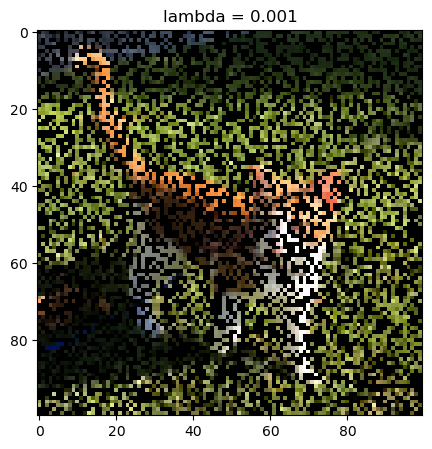

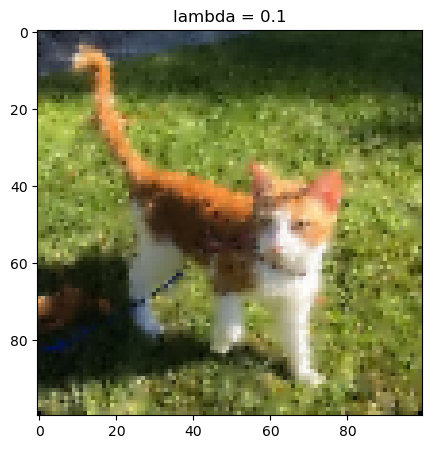

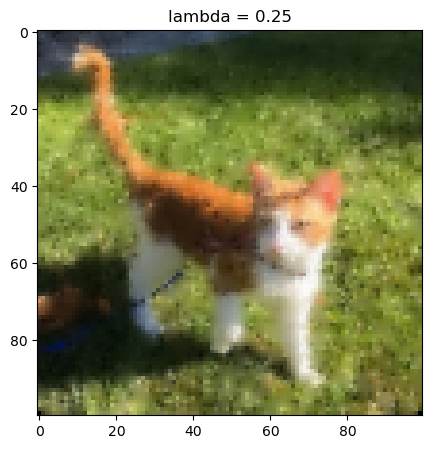

In [8]:
#In the context of regularization, λ determines the strength of the penalty applied to the function’s parameters.  
#The perfect choice of λ is challenging and dependson the use case and data set. Choosing a very small λ, 
#the regularization term has low impact on the loss function and the model is more likely to overfit. 
#A moderate λ fits the training data well and avoids overfitting. 
#A large λ dominates the loss function and it makes oversmooths the image, which leads to underfitting.

img1 = GD(g, omega, lmbda=0.001)
plt.figure(figsize=(15, 5))
plt.imshow(img1)
plt.title("lambda = 0.001")
plt.show()

img2 = GD(g, omega, lmbda=0.1)
plt.figure(figsize=(15, 5))
plt.imshow(img2)
plt.title("lambda = 0.1")
plt.show()

img3 = GD(g, omega, lmbda=0.25)
plt.figure(figsize=(15, 5))
plt.imshow(img3)
plt.title("lambda = 0.25")
plt.show()
